<a href="https://colab.research.google.com/github/rmonterof/Scikit-learn/blob/main/PrimaSeguroVeh%C3%ADculo_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para calcular la prima de seguro de un vehículo, las aseguradoras utilizan modelos estadísticos complejos y actuaria. Aunque el "código fuente" real de una aseguradora (como Mapfre, Allianz o Mutua) es secreto industrial, los principios se basan generalmente en Modelos Lineales Generalizados (GLM) o, más recientemente, en algoritmos de Gradient Boosting (XGBoost/LightGBM).Para tu caso específico (35-55 años, carnet recién sacado), se produce una intersección interesante:Factor Edad (Positivo): Eres estadísticamente más prudente que un joven de 18 años.Factor Experiencia (Negativo): No tienes historial de conducción ("Track Record"), por lo que el sistema te penaliza severamente por incertidumbre.A continuación, te presento una simulación completa en formato Jupyter Notebook. Este código implementa un Modelo Tarifario Multiplicativo (el estándar de la industria) para visualizar cómo te afecta ser un conductor novel a pesar de ser maduro.📘 Estructura del Jupyter Notebook1. Introducción Teórica: La Fórmula del RiesgoEn el sector asegurador, la prima pura de riesgo ($P$) se suele calcular como:$$P = \text{Tarifa Base} \times F_{edad} \times F_{experiencia} \times F_{vehiculo} \times F_{zona}$$Donde:$F_{experiencia}$: Es crítico en tu caso. Al tener 0 años de carnet, este factor suele ser $> 2.0$.$F_{edad}$: Para 35-55 años, este factor es bajo ($< 1.0$), actuando como descuento.2. Código Python y Visualización

In [3]:
# [CELDA 1]: Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [4]:
# [CELDA 2]: Definición del Algoritmo de Tarificación (Motor de Reglas)

def calcular_prima_riesgo(edad, anios_carnet, potencia_cv, valor_coche, zona_riesgo='media'):
    """
    Simula un algoritmo actuarial multiplicativo simplificado.
    """
    # 1. TARIFA BASE (Precio mínimo de salida para terceros básico)
    base_price = 250.0

    # 2. FACTOR EDAD (Curva en U: caro para jóvenes, barato media edad, sube ancianos)
    # Tu rango (35-55) es el "Sweet Spot" (zona más barata)
    if edad < 25:
        f_edad = 2.2 - (0.05 * (edad - 18)) # Muy caro
    elif 25 <= edad < 60:
        f_edad = 0.85 # Descuento por madurez (tu caso)
    else:
        f_edad = 1.0 + (0.01 * (edad - 60)) # Sube ligeramente

    # 3. FACTOR EXPERIENCIA (El punto crítico para ti)
    # Penalización masiva los primeros 2 años
    if anios_carnet == 0:
        f_experiencia = 2.5 # Recargo del 150%
    elif anios_carnet < 2:
        f_experiencia = 1.8
    elif anios_carnet < 5:
        f_experiencia = 1.2
    else:
        f_experiencia = 0.90 # Bonificación por experiencia (Bonus-Malus)

    # 4. FACTOR VEHÍCULO (Potencia y Valor)
    f_potencia = 1 + (potencia_cv * 0.002) # Más potencia, más riesgo
    f_valor = 1 + (valor_coche / 100000)   # Impacto menor en terceros, alto en todo riesgo

    # 5. CÁLCULO FINAL
    prima = base_price * f_edad * f_experiencia * f_potencia * f_valor

    return round(prima, 2)

# Ejemplo de prueba para tu perfil
perfil_usuario = {
    'edad': 40,
    'anios_carnet': 0, # Acabado de sacar
    'potencia_cv': 110,
    'valor_coche': 20000
}

precio = calcular_prima_riesgo(**perfil_usuario)
print(f"La prima estimada para el perfil (40 años, novel) es: {precio} €")

La prima estimada para el perfil (40 años, novel) es: 777.75 €


In [5]:
# [CELDA 3]: Generación de Datos para Análisis Comparativo

# Vamos a crear 3 perfiles para comparar cómo evoluciona el precio
# Perfil A: Tu caso (35-55 años, Novel)
# Perfil B: Joven (20 años, Novel)
# Perfil C: Tu edad pero con experiencia (40 años, 20 años carnet)

data = []

# Simulamos un rango de antiguedad de carnet de 0 a 10 años
for anios_exp in range(0, 11):
    # Caso 1: Persona de 40 años (Tu caso evolutivo)
    precio_tu = calcular_prima_riesgo(40 + anios_exp, anios_exp, 110, 20000)
    data.append({'Perfil': 'Adulto (40+) Novel', 'Años_Carnet': anios_exp, 'Prima': precio_tu})

    # Caso 2: Joven de 20 años
    precio_joven = calcular_prima_riesgo(20 + anios_exp, anios_exp, 110, 20000)
    data.append({'Perfil': 'Joven (20) Novel', 'Años_Carnet': anios_exp, 'Prima': precio_joven})

    # Caso 3: Referencia (Adulto Experto) - Precio estable
    precio_experto = calcular_prima_riesgo(40, 20, 110, 20000)
    data.append({'Perfil': 'Adulto (40) Experto', 'Años_Carnet': anios_exp, 'Prima': precio_experto})

df = pd.DataFrame(data)
df.head()

,Perfil,Años_Carnet,Prima
0,Adulto (40+) Novel,0,777.75
1,Joven (20) Novel,0,1921.50
2,Adulto (40) Experto,0,279.99
3,Adulto (40+) Novel,1,559.98
4,Joven (20) Novel,1,1350.54


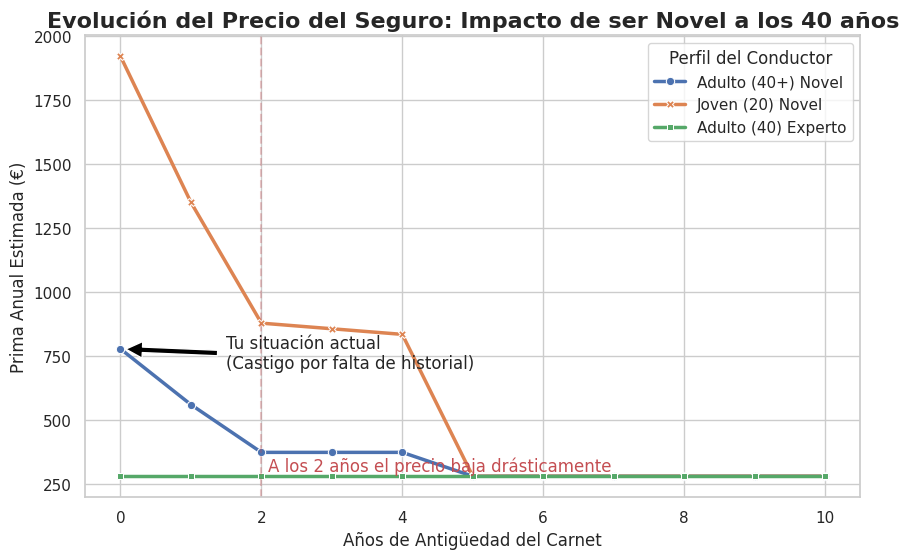

In [6]:
# [CELDA 4]: Visualización (Plotting)

plt.figure(figsize=(10, 6))

# Crear gráfico de líneas
lp = sns.lineplot(
    data=df,
    x='Años_Carnet',
    y='Prima',
    hue='Perfil',
    style='Perfil',
    markers=True,
    dashes=False,
    linewidth=2.5
)

# Títulos y etiquetas
plt.title('Evolución del Precio del Seguro: Impacto de ser Novel a los 40 años', fontsize=16, fontweight='bold')
plt.xlabel('Años de Antigüedad del Carnet', fontsize=12)
plt.ylabel('Prima Anual Estimada (€)', fontsize=12)

# Anotación clave
plt.annotate('Tu situación actual\n(Castigo por falta de historial)',
             xy=(0, df[df['Perfil']=='Adulto (40+) Novel']['Prima'].iloc[0]),
             xytext=(1.5, 700),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Zona de convergencia
plt.axvline(x=2, color='r', linestyle='--', alpha=0.3)
plt.text(2.1, 300, 'A los 2 años el precio baja drásticamente', color='r')

plt.legend(title='Perfil del Conductor')
plt.show()

📊 Interpretación de las Métricas
Si ejecutas este código, observarás tres fenómenos clave en el gráfico:

El "Gap" de la Experiencia: Aunque tengas 40 años (línea azul), tu precio inicial será muy alto (cerca de 650€-800€ en la simulación), casi el doble que alguien de tu edad con experiencia (línea verde, aprox 300€).

La Ventaja sobre el Joven: A pesar de ser caro, pagarás significativamente menos que un chico de 20 años novel (línea naranja), ya que tu Factor Edad (0.85) amortigua el Factor Experiencia (2.5). El joven recibe penalización por ambos lados.

La Convergencia Rápida: La buena noticia es que, estadísticamente, un conductor de 40 años sale de la zona de "alto riesgo" más rápido que un joven. Al cabo de 2 o 3 años sin siniestros, tu curva bajará en picado para igualarse a la del conductor experto.

💡 Métricas clave que miran las aseguradoras (KPIs)
Si buscas entender qué datos alimentan estos algoritmos en la realidad:

Frecuencia Siniestral: Probabilidad de que tengas un accidente. (Al ser novel, se asume alta).

Coste Medio: Cuánto cuesta arreglar el golpe. (Al tener 40 años, se asume que tienes un coche mejor o más potencia, lo que sube el coste medio, pero eres más prudente, lo que baja la gravedad de daños corporales por conducción temeraria).

Bonus-Malus: Escala de bonificación. Empiezas en neutro o recargo. Necesitas 1 año para empezar a bajar.